In [1]:
# Import des librairies

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split

# Pour créer le modèle

from sklearn.linear_model import Ridge, Lasso, LinearRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.svm import SVR

# Grid Search

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

# StandardScaler

from sklearn.preprocessing import StandardScaler

# Time

import timeit

# Pour le modèle baseline

from sklearn.metrics import r2_score

In [2]:
# On règle les paramètres de pandas et de la visualisation

sns.set(font_scale = 3,rc={'figure.figsize':(60,20)})

pd.options.display.max_columns = 200

pd.options.display.max_rows = 1000

pd.options.display.max_colwidth = 50

In [3]:
# Fonction pratique

def information_basique(data): 
    '''
    Affiche le .shape, .info, .describe d'un dataframe 
    Parameters :
    ----------
    data : pd.DataFrame
    Return:
    ------
    '''
    
    print('\033[1m'+'Shape :\n'+'\033[0m',data.shape,'\n')

    print('\033[1m'+'Info :'+'\033[0m')

    data.info()
    
    print('\033[1m'+'\nDescription :')
    
    display(data.describe())

def show_missing_data_graph(data):
    '''
    Affiche un graphique du % de remplissage de chaque colonne : 
    Parameters :
    ----------
    data : pd.DataFrame
    Return:
    ------
    '''
    missing_data = round((1 - data.isna().sum()/len(data)),3)
    label = missing_data.index

    sns.barplot(x = label, y = missing_data)
    plt.title('Donnée disponible',fontsize=100)
    plt.xticks(rotation=90)
    plt.tight_layout()
    
# pour une map de correlation un peu plus claire (le bout de code a été récupéré) 
def plot_correl_map(data) :
    correl = data.corr()
    mask = np.zeros_like(correl, dtype=bool) # all false with corr shape
    mask[np.triu_indices_from(mask)] = True # Return the indices for the upper-triangle of mask

    fig, ax = plt.subplots( figsize=(10,7) )
    sns.heatmap(correl, mask=mask, vmin=-1, cmap='coolwarm', annot=True, fmt='.1g',)
    plt.show()   

In [4]:
# On récupère la donnée

data_energy_path = 'donnée_new/data_energy.csv'

data_energy = pd.read_csv(data_energy_path,sep=',',low_memory=False)


In [5]:
data_energy

,CouncilDistrictCode_3,SiteEnergyUse(kBtu),ENERGYSTARScore,Haversine,NumberofFloors,CouncilDistrictCode_2,YearBuilt,NumberofBuildings,PropertyGFATotal,PrimaryPropertyType_Storage,PrimaryPropertyType_Medical
0,0,4.498447e+07,76.0,1.869936,10,0,1916,1.0,540360,0,0
1,0,1.539478e+06,95.0,9.715080,2,1,1961,1.0,56228,0,0
2,0,6.779173e+06,75.0,11.004175,2,0,1949,1.0,160645,0,0
3,0,4.483853e+08,8.0,9.326466,3,1,1992,1.0,494835,0,0
4,0,1.650279e+06,97.0,5.645825,2,0,1990,1.0,54986,0,0
...,...,...,...,...,...,...,...,...,...,...,...
996,0,4.420650e+06,9.0,10.054329,2,1,1929,1.0,24990,0,0
997,1,1.325973e+06,77.0,4.228254,3,0,2015,1.0,45000,0,0
998,0,5.026677e+05,75.0,3.160760,1,0,1952,1.0,13661,0,0
999,0,3.878100e+05,93.0,7.632217,1,1,1960,1.0,15398,0,0


In [6]:
# Pour préparer la comparaison des différents modèle plus rapidement, 

def create_report(regressor,X,y,grid,data_to_update,random_state = 0,random_search=False,comment=''):
    '''
    Scal les paramètres, fait un train test split, puis fait un grid search et renvoie les performances du modèle + le grid
    regressor : le modèle que l'on veut évaluer
    X : les paramètres non scalé
    y : la target
    grid : les parametres pour le grid search
    data_to_update : un Dataframe qui sera mis à jour avec le nouvelles donnée
    random_state : le random state pour le train test split 0
    return : le grid search fit et un dataframe avec l'evaluation du modèle
    '''
    start_time = timeit.default_timer()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state)

    # On Scale le X_train

    standart_scale = StandardScaler()

    standart_scale.fit(X_train)

    X_train_scaled = standart_scale.transform(X_train)


    X_test_scaled = standart_scale.transform(X_test)
    
    if random_search :
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        search = RandomizedSearchCV(estimator = regressor,scoring = 'r2',\
                                       param_distributions = grid, n_iter = 10, cv = 5,\
                                       verbose=2, random_state=random_state, n_jobs = -1)
        # Fit the random search model
        search.fit(X_train_scaled, y_train)
    else :    
        search = GridSearchCV(regressor, grid, 
                                   scoring = 'r2',
                                   cv = 5,
                                   n_jobs=-1 # paralellize computation
                                  )
        search.fit(X_train_scaled,y_train)
    
    
    
    train_pred = search.best_estimator_.predict(X_train_scaled)
    test_pred = search.best_estimator_.predict(X_test_scaled)
    
    parameter = {'model':[f'{regressor}'],
    'best_params':[search.best_params_],
    'r2_score_cv':[search.best_score_],
    'r2_score_train': [search.best_estimator_.score(X_train_scaled,y_train)],
    'r2_score_test': [search.best_estimator_.score(X_test_scaled,y_test)],
    'mean_res':[np.mean(test_pred-y_test)],
    'std_res':[np.std(test_pred-y_test)],
    'time (s)':[(timeit.default_timer() - start_time)],
    'commentaire':comment
    }
    return search,pd.concat([data_to_update,pd.DataFrame(parameter)],axis=0)

In [7]:
# On crée notre X et notre y

# On a testé pour vérifier si les résultats s'améliorait en supprimant certains outliers
#data_energy = data_energy[data_energy['SiteEnergyUse(kBtu)']>0]
#data_energy = data_energy[np.log(data_energy["SiteEnergyUse(kBtu)"])<16]
#data_energy = data_energy[np.log(data_energy["SiteEnergyUse(kBtu)"])>12]

y = np.log(data_energy[data_energy['SiteEnergyUse(kBtu)']>0]['SiteEnergyUse(kBtu)'])
X = data_energy[data_energy['SiteEnergyUse(kBtu)']>0].drop(columns =['SiteEnergyUse(kBtu)'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
standart_scale = StandardScaler()

standart_scale.fit(X_train)

X_train_scaled = standart_scale.transform(X_train)


X_test_scaled = standart_scale.transform(X_test)

In [9]:
# On crée notre X sans energystarscore


X_no = data_energy[data_energy['SiteEnergyUse(kBtu)']>0].drop(columns =['SiteEnergyUse(kBtu)','ENERGYSTARScore'])

In [10]:
# On crée le baseline modèle

# Notre modèle prédis systématiquement la moyenne de y_train

mean_baseline = y_train.mean()

prediction_baseline_train = np.full(y_train.shape,mean_baseline)

# On évalue son R2 score

score_base_train = r2_score(y_train,prediction_baseline_train)

prediction_baseline_test = np.full(y_test.shape,mean_baseline)

score_base_test = r2_score(y_test,prediction_baseline_test)

mean_baseline = np.mean(prediction_baseline_test-y_test)
std_baseline = np.std(prediction_baseline_test-y_test)

In [11]:
# On crée le report vide ( avec la baseline dedans)

report = pd.DataFrame({'model': ['Baseline'],'best_params':[''],'r2_score_cv':[''],'r2_score_train':[score_base_train],\
                       'r2_score_test':[score_base_test] ,'mean_res':[mean_baseline],\
                       'std_res':[std_baseline],'time (s)':[''],'commentaire':['']})
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.0,-0.00238,0.058362,1.196231,,


In [12]:
# Linear Regression
grid = {}
search_1,report = create_report(LinearRegression(),X,y,grid,report,0)
search_1_no,report = create_report(LinearRegression(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.000000,-0.002380,0.058362,1.196231,,
0,LinearRegression(),{},0.55914,0.582693,0.547749,0.040892,0.803420,1.600013,
0,LinearRegression(),{},0.511942,0.533006,0.457034,0.007626,0.881424,1.13654,No energyStar


In [13]:
# Ridge

grid = {'alpha': np.logspace(-3,3,1000)}
search_2,report = create_report(Ridge(),X,y,grid,report,0)
search_2_no,report = create_report(Ridge(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.000000,-0.002380,0.058362,1.196231,,
0,LinearRegression(),{},0.55914,0.582693,0.547749,0.040892,0.803420,1.600013,
0,LinearRegression(),{},0.511942,0.533006,0.457034,0.007626,0.881424,1.13654,No energyStar
0,Ridge(),{'alpha': 0.001},0.55914,0.582693,0.547749,0.040892,0.803420,1.51029,
0,Ridge(),{'alpha': 0.001},0.511942,0.533006,0.457034,0.007627,0.881424,0.935169,No energyStar


In [14]:
# Lasso
grid = {'alpha': np.linspace(0.02,0.03,100)}
search_3,report = create_report(Lasso(),X,y,grid,report,0)
search_3_no,report = create_report(Lasso(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.000000,-0.002380,0.058362,1.196231,,
0,LinearRegression(),{},0.55914,0.582693,0.547749,0.040892,0.803420,1.600013,
0,LinearRegression(),{},0.511942,0.533006,0.457034,0.007626,0.881424,1.13654,No energyStar
0,Ridge(),{'alpha': 0.001},0.55914,0.582693,0.547749,0.040892,0.803420,1.51029,
0,Ridge(),{'alpha': 0.001},0.511942,0.533006,0.457034,0.007627,0.881424,0.935169,No energyStar
0,Lasso(),{'alpha': 0.023535353535353534},0.562294,0.578363,0.542502,0.038072,0.808217,0.183029,
0,Lasso(),{'alpha': 0.02},0.513528,0.529794,0.455056,0.007631,0.883029,0.172648,No energyStar


In [15]:
# SVR

grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
search_4,report = create_report(SVR(),X,y,grid,report,0)
search_4_no,report = create_report(SVR(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.000000,-0.002380,0.058362,1.196231,,
0,LinearRegression(),{},0.55914,0.582693,0.547749,0.040892,0.803420,1.600013,
0,LinearRegression(),{},0.511942,0.533006,0.457034,0.007626,0.881424,1.13654,No energyStar
0,Ridge(),{'alpha': 0.001},0.55914,0.582693,0.547749,0.040892,0.803420,1.51029,
0,Ridge(),{'alpha': 0.001},0.511942,0.533006,0.457034,0.007627,0.881424,0.935169,No energyStar
0,Lasso(),{'alpha': 0.023535353535353534},0.562294,0.578363,0.542502,0.038072,0.808217,0.183029,
0,Lasso(),{'alpha': 0.02},0.513528,0.529794,0.455056,0.007631,0.883029,0.172648,No energyStar
0,SVR(),{'kernel': 'rbf'},0.66407,0.756774,0.636263,0.019010,0.721204,0.234549,
0,SVR(),{'kernel': 'rbf'},0.60661,0.679639,0.549604,-0.041988,0.801710,0.24218,No energyStar


In [16]:
# Random Forest

# Number of trees in random forest
# original
# n_estimators = [10,20,30,50]

n_estimators = [47,50,55]

# Number of features to consider at every split

# original
# max_features = ['auto', 'sqrt']

max_features = ['auto']

# Maximum number of levels in tree

# original
# max_depth = [2,3,4]

max_depth = [3]

# Minimum number of samples required to split a node

# original
#min_samples_split = [3, 5, 10]

min_samples_split = [10,12,15]

# Minimum number of samples required at each leaf node

# original
#min_samples_leaf = [ 3, 4, 5]

min_samples_leaf = [4, 5,6]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
search_5,report = create_report(RandomForestRegressor(),X,y,random_grid,report,0)

search_5_no,report = create_report(RandomForestRegressor(),X_no,y,random_grid,report,0,comment='No energyStar')
# Pour voir toute la colonne

pd.options.display.max_colwidth = None

report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.000000,-0.002380,0.058362,1.196231,,
0,LinearRegression(),{},0.55914,0.582693,0.547749,0.040892,0.803420,1.600013,
0,LinearRegression(),{},0.511942,0.533006,0.457034,0.007626,0.881424,1.13654,No energyStar
0,Ridge(),{'alpha': 0.001},0.55914,0.582693,0.547749,0.040892,0.803420,1.51029,
0,Ridge(),{'alpha': 0.001},0.511942,0.533006,0.457034,0.007627,0.881424,0.935169,No energyStar
0,Lasso(),{'alpha': 0.023535353535353534},0.562294,0.578363,0.542502,0.038072,0.808217,0.183029,
0,Lasso(),{'alpha': 0.02},0.513528,0.529794,0.455056,0.007631,0.883029,0.172648,No energyStar
0,SVR(),{'kernel': 'rbf'},0.66407,0.756774,0.636263,0.019010,0.721204,0.234549,
0,SVR(),{'kernel': 'rbf'},0.60661,0.679639,0.549604,-0.041988,0.801710,0.24218,No energyStar
0,RandomForestRegressor(),"{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 50}",0.69848,0.737041,0.669692,0.014280,0.687355,0.865359,


In [17]:
# Gradient Boosting

grid = {'n_estimators':np.arange(1,100,1)}
search_6,report = create_report(GradientBoostingRegressor(),X,y,grid,report,0)
search_6_no,report = create_report(GradientBoostingRegressor(),X_no,y,grid,report,0,comment='No energyStar')
report.reset_index(drop=True)

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,0.000000,-0.002380,0.058362,1.196231,,
1,LinearRegression(),{},0.55914,0.582693,0.547749,0.040892,0.803420,1.600013,
2,LinearRegression(),{},0.511942,0.533006,0.457034,0.007626,0.881424,1.13654,No energyStar
3,Ridge(),{'alpha': 0.001},0.55914,0.582693,0.547749,0.040892,0.803420,1.51029,
4,Ridge(),{'alpha': 0.001},0.511942,0.533006,0.457034,0.007627,0.881424,0.935169,No energyStar
5,Lasso(),{'alpha': 0.023535353535353534},0.562294,0.578363,0.542502,0.038072,0.808217,0.183029,
6,Lasso(),{'alpha': 0.02},0.513528,0.529794,0.455056,0.007631,0.883029,0.172648,No energyStar
7,SVR(),{'kernel': 'rbf'},0.66407,0.756774,0.636263,0.019010,0.721204,0.234549,
8,SVR(),{'kernel': 'rbf'},0.60661,0.679639,0.549604,-0.041988,0.801710,0.24218,No energyStar
9,RandomForestRegressor(),"{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 50}",0.69848,0.737041,0.669692,0.014280,0.687355,0.865359,


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
standart_scale = StandardScaler()

standart_scale.fit(X_train)

X_train_scaled = standart_scale.transform(X_train)


X_test_scaled = standart_scale.transform(X_test)

In [19]:
# On Selectionne notre meilleur modèle d'après le report. RandomForest a le meilleur score tout en évitant l'overfiting.
# Gradiant Boosting a le meilleur score, mais il overfit trop.

train_pred = search_5.best_estimator_.predict(X_train_scaled)
test_pred = search_5.best_estimator_.predict(X_test_scaled)

Text(0.5, 1.0, 'Repartition des résidus')

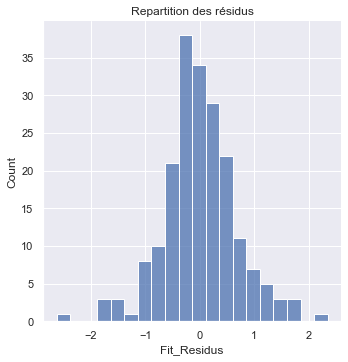

In [20]:
# On plot la répartition des résidus

sns.set()

sns.displot(y_test-test_pred)
plt.xlabel('Fit_Residus')
plt.title('Repartition des résidus')

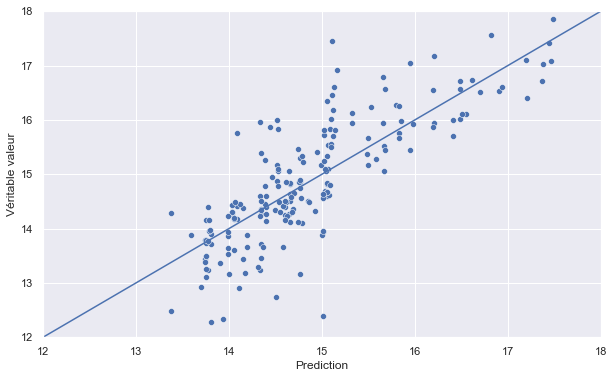

In [21]:
# Plot Prédiction contre valeur réel

fig,ax=plt.subplots(figsize=((10,6)))
sns.set(font_scale=0.5)
sns.scatterplot(x=test_pred, y=y_test)
#sns.scatterplot(x=train_pred, y=y_train)
plt.xlim([12,18])
plt.ylim([12,18])
plt.plot([12,18],[12,18])
plt.xlabel('Prediction')
plt.ylabel('Véritable valeur');


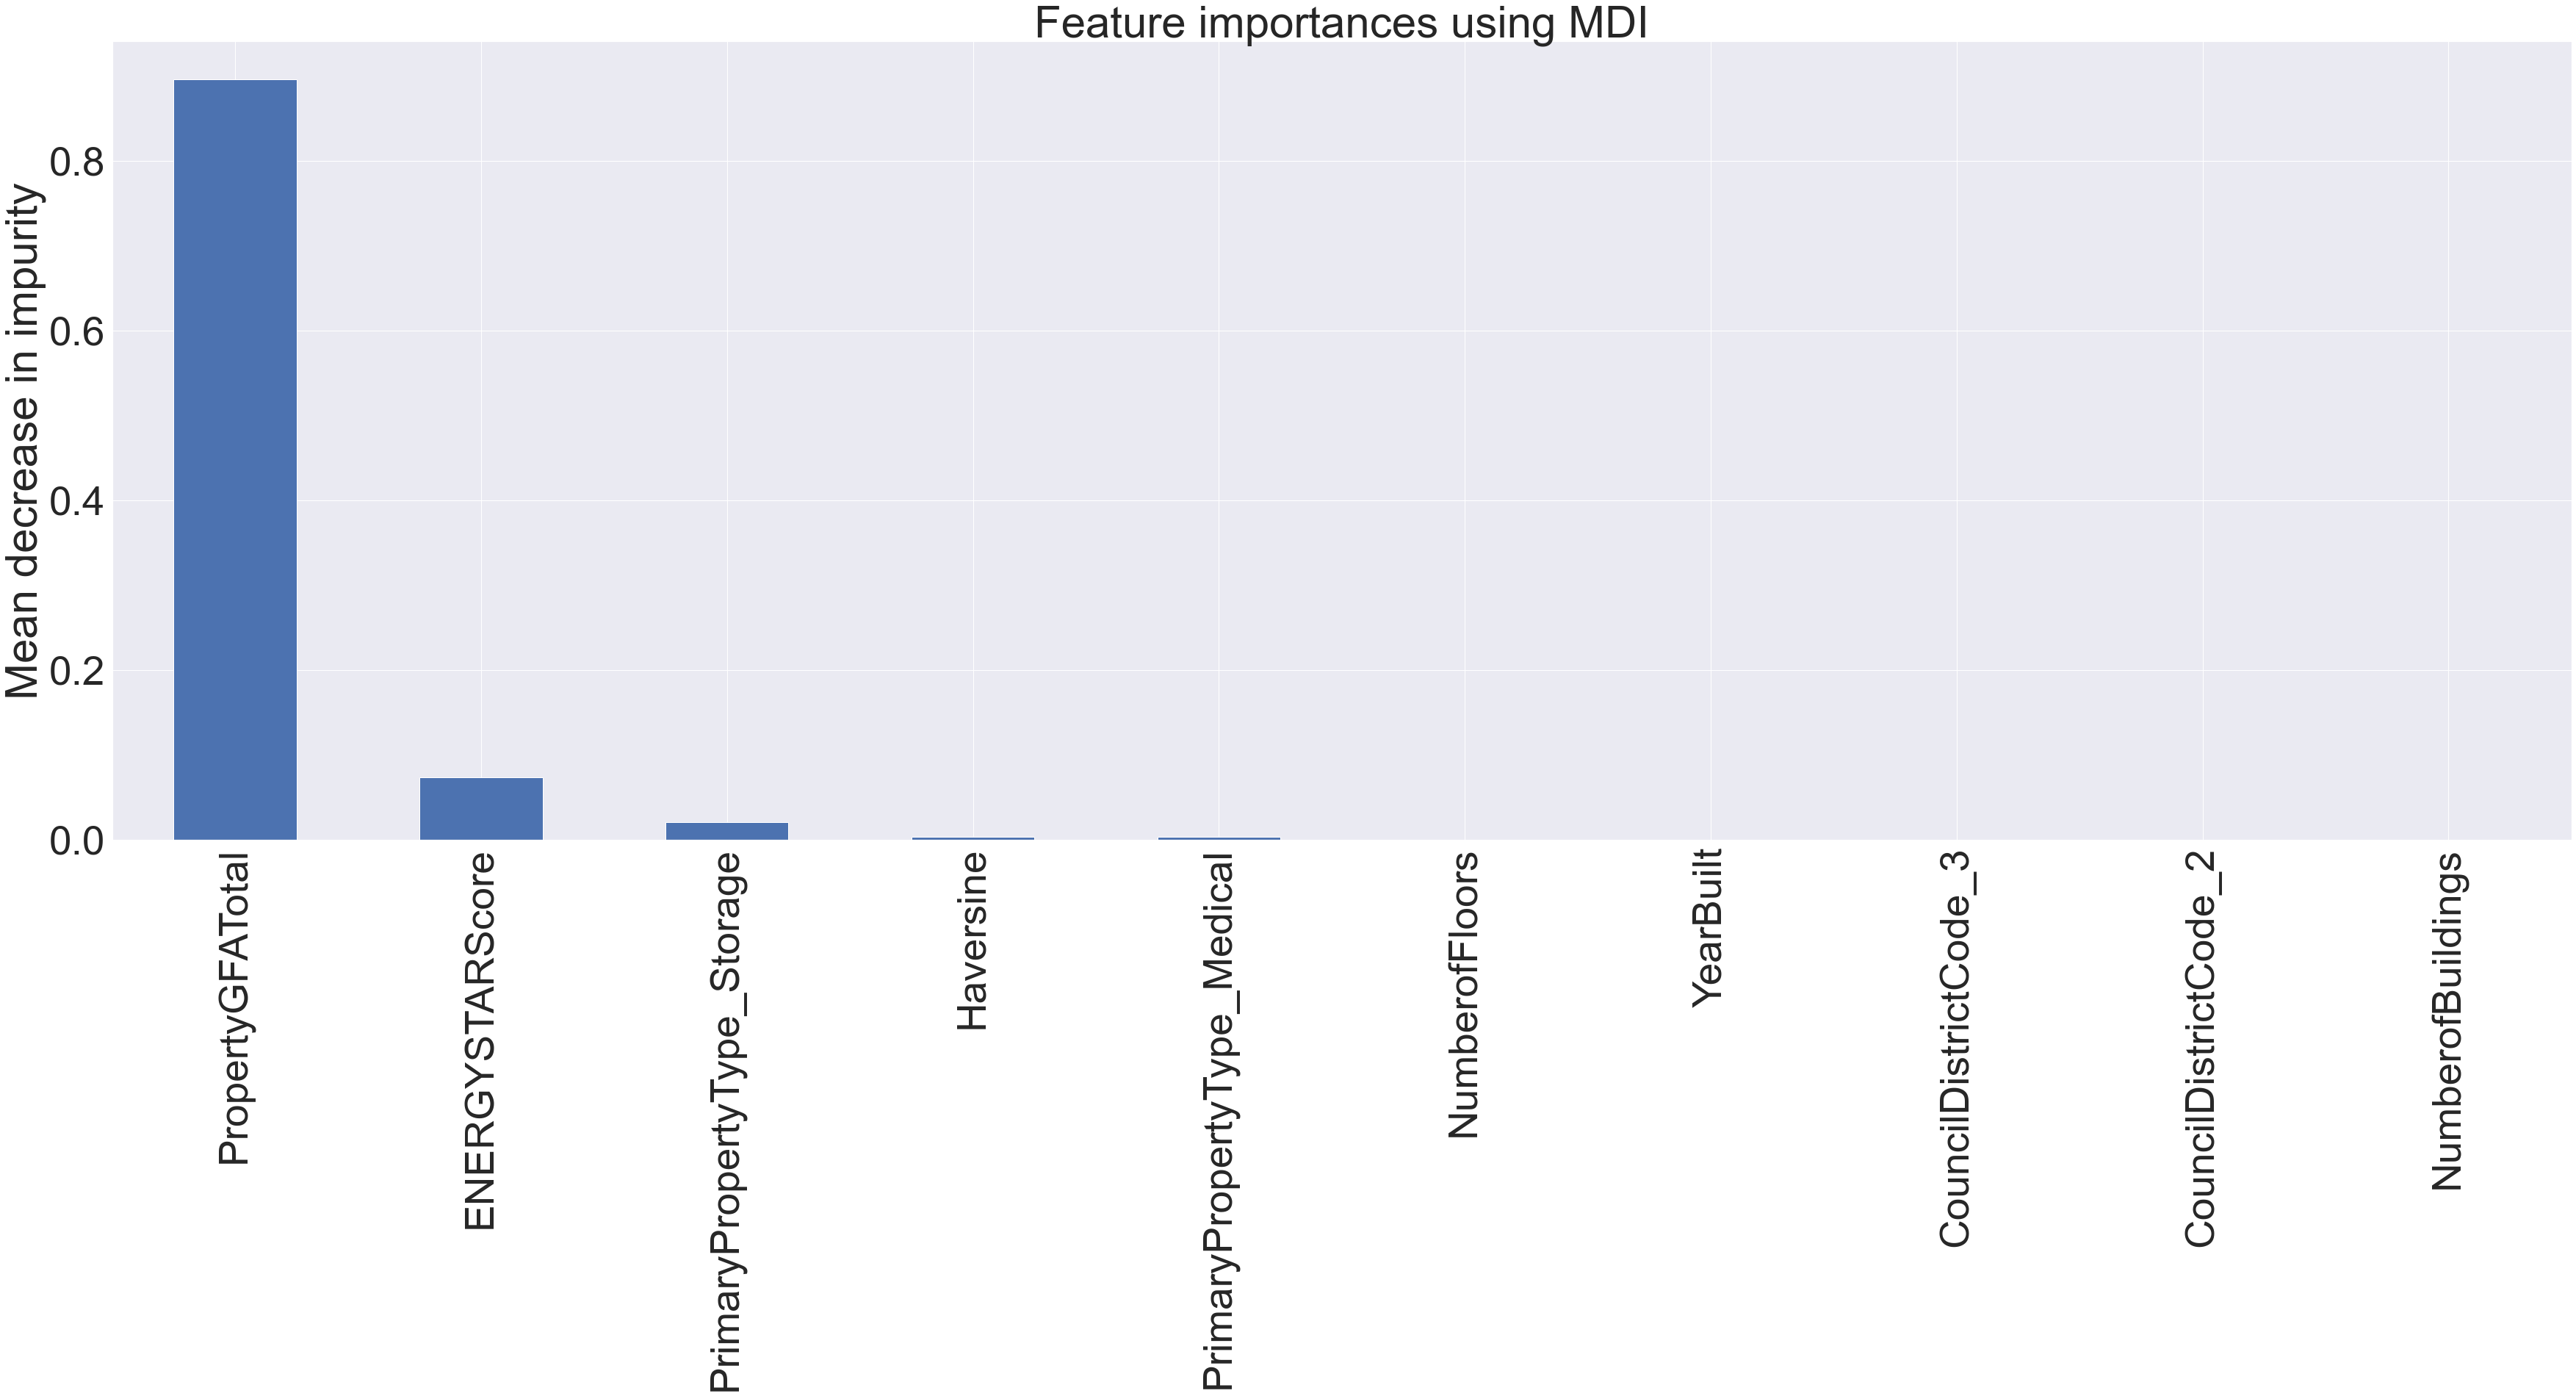

In [22]:
# On observe le feature importance également


sns.set(font_scale = 5,rc={'figure.figsize':(60,20)})

importances  = search_5.best_estimator_.feature_importances_

feature_names = [f"{i}" for i in (X.columns)]
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

feature_names = [f"feature {i}" for i in (X.columns)]

forest_importances.plot.bar()

plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity");
